Pulls in the buy and sell orders from bittensor.exchange and creates a market depth chart from it.

In [23]:
import requests
from bs4 import BeautifulSoup
import sys
import pickle

url = "https://bittensor.exchange/"
r = requests.get(url)
print(r.status_code)
soup = BeautifulSoup(r.content, "html.parser")

table_divs = soup.find_all("div", class_="col")

orders = []
for table_div in table_divs:
    # Find the table in the div
    order_table = table_div.find('table')

    column_names = []
    for th in order_table.thead.tr.find_all('th'):
        column_names.append(th.text)
    
    for tr in order_table.tbody.find_all('tr'):
        row_data = {}
        for i, td in enumerate(tr.find_all('td')):
            if "Buy" in td.text: 
                # They have a Buy button on sell orders
                row_data[column_names[i]] = "sell"
            elif "Sell" in td.text:
                row_data[column_names[i]] = "buy"
            else:
                row_data[column_names[i]] = td.text

        orders.append(row_data)

# Because I didn't want to keep requesting the page
with open("orders.pkl", "wb") as f:
    pickle.dump(orders, f)


200


In [45]:
import pickle
import pandas as pd

with open("orders.pkl", "rb") as f:
    orders = pickle.load(f)

print(orders[0])

# Convert orders into a dataframe
df = pd.DataFrame(orders)

df = df.rename(columns={"Total": "Volume (USD)", "Volume": "Volume (TAO)", "Price": "Price (USD)", "": "Type"})

df['Volume (USD)'] = df['Volume (USD)'].replace(
    {'\\n': '', '\$': '', ',': ''}, regex=True).str.strip()
df['Volume (USD)'] = pd.to_numeric(df['Volume (USD)'])

df['Volume (TAO)'] = df['Volume (TAO)'].replace(
    {'τ': '', ',': ''}, regex=True).str.strip()
df['Volume (TAO)'] = pd.to_numeric(df['Volume (TAO)'])

df['Price (USD)'] = df['Price (USD)'].replace(
    {r'\/Tao': '', '\$': '', ',': ''}, regex=True).str.strip()
# df['Price (USD)'] = pd.to_numeric(df['Price (USD)'])
df['Price (USD)'] = df['Price (USD)'].astype('float')

print(df.head())
print(df.tail())



{'Price': '37.00 $/Tao', 'Volume': 'τ 166.00', 'Total': '\n$ 6,142.00\n', '': 'buy'}
   Price (USD)  Volume (TAO)  Volume (USD) Type
0         37.0         166.0        6142.0  buy
1         37.9          50.0        1895.0  buy
2         38.0         500.0       19000.0  buy
3         38.0         130.0        4940.0  buy
4         38.4          25.0         960.0  buy
     Price (USD)  Volume (TAO)  Volume (USD)  Type
108         12.0         20.45        245.36  sell
109         11.0         10.10        111.15  sell
110         10.5         10.24        107.49  sell
111         10.0         10.07        100.71  sell
112          6.0        100.42        602.52  sell


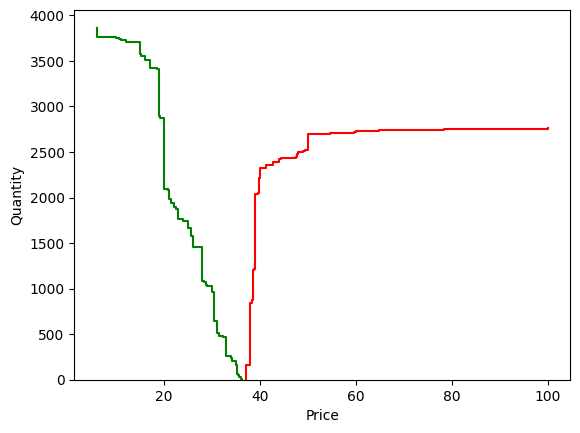

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create the market depth chart
fig, ax = plt.subplots()
sns.ecdfplot(x="Price (USD)", weights="Volume (TAO)", stat="count",
             complementary=True, data=df.query("Type == 'sell'"),
             color="green", ax=ax)
sns.ecdfplot(x="Price (USD)", weights="Volume (TAO)", stat="count", 
             data=df.query("Type == 'buy'"), color="red",
             ax=ax)
ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()


